Necessary packages:

In [1]:
import glob
import os
import warnings


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pydicom
from pydicom.data import get_testdata_files
from sklearn.model_selection import train_test_split

from IPython.display import Markdown, display

 # Import functions from the module
import importlib
import help_files._0_definitions 
import  help_files._1_visuals_script
# import  help_files._01_load_data
 # Reload the module to apply the changes to the script
importlib.reload(help_files._0_definitions)
importlib.reload(help_files._1_visuals_script)
# importlib.reload(help_files._01_load_data)
import  help_files._1_visuals_script  as pauls_vs
# Group by 'condition', 'level', and 'severity' and count occurrences
from help_files._0_definitions import count_severity_by_condition_level 
# Define the path
from pathlib import Path

pd.set_option("display.width", 1000)  # Set a large width to prevent line wrapping
 

In [2]:
### In definitions are all the functions that are used in the notebook and globals
with open("help_files/_0_definitions.py") as file:
    exec(file.read())

In [3]:
# Load the data from _01_load_data
file_names = ["X_train.csv", "X_train_coor.csv", "X_train_des.csv"]
dataframes = [pd.read_csv(data_path_vor / file_name) for file_name in file_names]
X_train, X_train_coor, X_train_des = dataframes

### X_train manipulation

In [ ]:
X_train

In [ ]:
# Summary statistics of the dataframe
summary = X_train.describe(include='all')

# Information about the dataframe
info = X_train.info()

# Display the summary and info
print(summary)
print(info)

In [ ]:
X_train.dtypes

In [ ]:
# List of columns to iterate through: 
columns_to_iterate = [
    'spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
    'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1', 'left_neural_foraminal_narrowing_l1_l2',
    'left_neural_foraminal_narrowing_l2_l3', 'left_neural_foraminal_narrowing_l3_l4', 'left_neural_foraminal_narrowing_l4_l5',
    'left_neural_foraminal_narrowing_l5_s1', 'right_neural_foraminal_narrowing_l1_l2', 'right_neural_foraminal_narrowing_l2_l3',
    'right_neural_foraminal_narrowing_l3_l4', 'right_neural_foraminal_narrowing_l4_l5', 'right_neural_foraminal_narrowing_l5_s1',
    'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3', 'left_subarticular_stenosis_l3_l4',
    'left_subarticular_stenosis_l4_l5', 'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
    'right_subarticular_stenosis_l2_l3', 'right_subarticular_stenosis_l3_l4', 'right_subarticular_stenosis_l4_l5',
    'right_subarticular_stenosis_l5_s1'
]


# Example operation: Fill missing values with 'Unknown'
for column in columns_to_iterate:
    X_train[column] = X_train[column].map({'Normal/Mild': 1, 'Moderate': 2, 'Severe': 3})

X_train

Disribution of different damages in spine

In [ ]:
# Create an empty list to store the distribution data
distribution_data = []

# Calculate the distribution for each column
for column in columns_to_iterate:
    counts = X_train[column].value_counts().sort_index()
    total_counts = counts.sum()
    distribution_data.append({
        'Condition': column,
        'Normal/Mild': counts.get(1.0, 0),
        'Moderate': counts.get(2.0, 0),
        'Severe': counts.get(3.0, 0)
    })
    distribution_data[-1]['Normal/Mild (%)'] = (counts.get(1.0, 0) / total_counts) * 100
    distribution_data[-1]['Moderate (%)'] = (counts.get(2.0, 0) / total_counts) * 100
    distribution_data[-1]['Severe (%)'] = (counts.get(3.0, 0) / total_counts) * 100

# Convert the list to a DataFrame
distribution_df = pd.DataFrame(distribution_data)

# Display the distribution DataFrame
print(distribution_df)

 


In [ ]:
X_train_des

In [ ]:
## reshaping the data from wide to long
reshape_list = ['spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4', 'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1', 'left_neural_foraminal_narrowing_l1_l2', 'left_neural_foraminal_narrowing_l2_l3', 'left_neural_foraminal_narrowing_l3_l4', 'left_neural_foraminal_narrowing_l4_l5', 'left_neural_foraminal_narrowing_l5_s1', 'right_neural_foraminal_narrowing_l1_l2', 'right_neural_foraminal_narrowing_l2_l3', 'right_neural_foraminal_narrowing_l3_l4', 'right_neural_foraminal_narrowing_l4_l5', 'right_neural_foraminal_narrowing_l5_s1', 'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3', 'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5', 'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2', 'right_subarticular_stenosis_l2_l3', 'right_subarticular_stenosis_l3_l4', 'right_subarticular_stenosis_l4_l5', 'right_subarticular_stenosis_l5_s1']  
# Assuming df is your DataFrame
reshaped_train = pd.melt(X_train, 
                  id_vars=["study_id"],  # Keep study_id as is
                  var_name="categorie",  # New column for the condition names
                  value_name="severity")   # New column for the values

# Display the reshaped DataFrame
# Ensure the file is not open in another program and you have write permissions
# reshaped_train.to_csv(path / "starfor_sorting_new.csv",  index=False)
 
 
X_train = reshaped_train
X_train = X_train.sort_values(by=['study_id', 'categorie'], ignore_index=True)
X_train.head()

In [ ]:
# Split the string into two parts: 'spinal_canal_stenosis' and 'l1_l2'
split_columns = X_train['categorie'].str.rsplit('_', n=2)
# Combine the first part as 'condition' and the last two parts as 'level'
X_train['condition'] = split_columns.str[0]
X_train['level'] = split_columns.str[1] + '_' + split_columns.str[2]

X_train 

In [ ]:
## adjusting srtings: disenabling the _ and making all lower case
X_train['condition'] = X_train['condition'].str.replace('_', ' ')
X_train['level'] = X_train['level'].str.replace('_', '/')


X_train_coor['condition'] = X_train_coor['condition'].str.lower()
X_train_coor['level'] = X_train_coor['level'].str.lower()
X_train.head()

### Select which kind of damage

In [ ]:
# keep only left neural foraminal narrowing l4/l5
# Filter the DataFrame to keep only rows where the condition is either left_subarticular_stenosis_l4_l5 or right_subarticular_stenosis_l4_l5
filtered_df = X_train[(X_train['condition'].str.contains('left neural foraminal narrowing')) & (X_train['level'] == 'l5/s1')]
print(filtered_df)

X_train = filtered_df


In [ ]:
X_train 

In [ ]:
# Group by 'categorie' and 'condition', then count the occurrences of each severity level
severity_counts = X_train.groupby(['categorie', 'condition'])['severity'].value_counts().unstack(fill_value=0)
# Display the result
print(severity_counts)



In [ ]:
unique_study_ids_train = X_train['study_id'].nunique()
unique_study_ids_train_coor = X_train_coor['study_id'].nunique()

print(f"Number of unique study_id in X_train: {unique_study_ids_train}")
print(f"Number of unique study_id in X_train_coor: {unique_study_ids_train_coor}")

In [17]:
 # get rid of persons with no coordinates
X_train = X_train[X_train['study_id'].isin(X_train_coor['study_id'])]

In [ ]:
unique_study_ids_train = X_train['study_id'].nunique()
unique_study_ids_train_coor = X_train_coor['study_id'].nunique()

print(f"Number of unique study_id in X_train: {unique_study_ids_train}")
print(f"Number of unique study_id in X_train_coor: {unique_study_ids_train_coor}")

merging X_train and X_train_coor 

In [ ]:
# Perform a left join between merged_df an X_train on multiple variables
merged_df = pd.merge(X_train, X_train_coor, on=['study_id', 'condition', 'level'], how='left')
# Display the merged DataFrame

merged_df = merged_df.sort_values(by=['categorie'], ignore_index=True) 
merged_df.head()

In [ ]:
# Group by 'categorie' and 'condition', then count the occurrences of each severity level
severity_counts = X_train.groupby(['categorie', 'condition'])['severity'].value_counts().unstack(fill_value=0)
# Display the result
print(severity_counts)

some statistics of data set

In [ ]:
# Count total rows in each DataFrame before the merge
print(f"Rows in X_train: {len(X_train)}")
print(f"Rows in X_train_coor: {len(X_train_coor)}")

# Count total rows in the merged DataFrame
print(f"Rows in merged_df: {len(merged_df)}")

# Find out how many rows have missing values in columns from X_train_coor after the merge
# Assuming columns from X_train_coor start with a common prefix or are listed in a known list
columns_from_X_train_coor = [col for col in X_train_coor.columns if col not in ['study_id', 'condition', 'level']]
missing_rows = merged_df[columns_from_X_train_coor].isnull().all(axis=1).sum()

# Create a new DataFrame for study_ids with at least one row having missing values in columns from X_train_coor
missing_study_ids = merged_df[merged_df[columns_from_X_train_coor].isnull().any(axis=1)]['study_id'].unique()
missing_persons_df = merged_df[merged_df['study_id'].isin(missing_study_ids)]
missing_persons_df = missing_persons_df.sort_values(by=['study_id', 'categorie'], ignore_index=True)
 

print(f"Rows in merged_df without matching rows in X_train_coor: {missing_rows}")
print(f"Rows in merged_df with matches from X_train_coor: {len(merged_df) - missing_rows}")

In [ ]:
missing_persons_df.head()

In [ ]:
# drop rows with missing values in columns from X_train_coor
merged_df = merged_df.dropna(subset=columns_from_X_train_coor)
display(Markdown('<span style="color:red">later on to take it back to the original shape : 48692</span>'))
merged_df

In [ ]:
# Group by 'categorie' and 'condition', then count the occurrences of each severity level
severity_counts = merged_df.groupby(['categorie', 'condition'])['severity'].value_counts().unstack(fill_value=0)
# Display the result
print(severity_counts)

In [ ]:
merged_df

Folder with images: preparing paths for merging with main data 

 define which mri type adequate for my 

In [ ]:
X_train_des.dtypes

In [ ]:
X_train_des = X_train_des[X_train_des['series_description'] == 'Sagittal T2/STIR']
X_train_des.head()

Paths to images constructing data frame: two options how to do

In [ ]:
# using X_train_desÖ Ecxell table is better than taking the path from the folders 
import re

def paths_to_images(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        
        # List images in the series directory
        images = os.listdir(series_dir)
        # Create full paths for each image
        image_paths.extend([os.path.join(series_dir, img) for img in images])
        
    return image_paths

image_paths = paths_to_images(X_train_des, os.path.join("data/train_images_origin"))

# Sort the image paths to ensure numerical order
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    return [int(part) if part.isdigit() else part for part in parts]

image_paths = sorted(image_paths, key=numerical_sort)
image_paths[:75]

df_image_paths = pd.DataFrame(image_paths, columns=['image_path'])
df_image_paths.head()

In [ ]:
""" # brauche ich nicht Using real folders and images:  
# path to images folder and images inside the folder
import re
# Define the main directory
main_dir = "data/train_images"

def paths_to_images_2(main_dir):
    image_paths = []
    # Walk through the directory structure starting from the main directory
    for root, subdirs, files in os.walk(main_dir):
        for file in files:
            # Create the full path for each image
            print(file)
            file_path = os.path.join(root, file)
            image_paths.append(file_path)

    return image_paths

paths_to_images_2(main_dir)



################   sort path images in numerical order  
# Define the main directory
main_dir = "data/train_images"

# Get the image paths
image_paths2 = paths_to_images_2(main_dir)

# Sort the image paths to ensure numerical order
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    return [int(part) if part.isdigit() else part for part in parts]

image_paths2 = sorted(image_paths2, key=numerical_sort)
image_paths2[:75]

df_image_paths2 = pd.DataFrame(image_paths2, columns=['image_path'])
df_image_paths2.head()
 
"""

In [ ]:
df_image_paths['image_path'] = df_image_paths['image_path'].str.replace('\\', '/')
df_image_paths.head()

In [ ]:
# Split the path and extract the study_id: make integer type of study_id
def safe_int_conversion(x):
    try:
        return int(x)
    except OverflowError:
        return None  # or handle it in another way

df_image_paths['study_id'] = df_image_paths['image_path'].apply(lambda x: safe_int_conversion(x.split('/')[2]))
df_image_paths['study_id'] = df_image_paths['study_id'].astype(int)
df_image_paths.head(75)

In [ ]:
df_image_paths.dtypes

In [ ]:
# keep only selected persons 
from help_files._0_definitions import keep_persons, study_ids_to_keep, all_persons
voraluf = keep_persons(df_image_paths, study_ids_to_keep, all_persons)
df_image_paths = voraluf
df_image_paths

Join  X_train and df_image_paths

In [ ]:
""" some checks 
df_image_paths['count'] = df_image_paths.groupby('study_id').cumcount() + 1
df_image_paths['count_per_person'] = df_image_paths.groupby('study_id')['study_id'].transform('count')
df_image_paths['mean_per_of_raws'] = df_image_paths.groupby('study_id').first()['count_per_person'].mean()
df_image_paths['first_row_flag'] = df_image_paths.groupby('study_id').cumcount().apply(lambda x: 1 if x == 0 else 0)
df_image_paths['mean_per_of_raws2'] = np.where(df_image_paths['first_row_flag'] == 1, df_image_paths['count_per_person'].mean(), np.nan)
df_image_paths.head(75)

print("at average there are 81 images per person")
"""

merign: 1:to many left join: df_image_paths merged to merged_df

In [ ]:
# join 1 to many: X_train and df_image_paths
df_end = merged_df.merge(df_image_paths, on='study_id', how='left')
df_end.head()


In [ ]:
# Call the function count_severity_by_condition_level for checking the count of severity by condition and level
 
print("\nMerged DataFrame:")
count_severity_by_condition_level(df_end)

In [ ]:
# join 1 to many: X_train and df_image_paths

df_end = df_end.drop(columns=['categorie', 'instance_number'])
df_end.shape

# Define data_path_vor
 
 
df_end.head()   

In [ ]:
# Call the function count_severity_by_condition_level for checking the count of severity by condition and level
 
print("\nMerged DataFrame:")
count_severity_by_condition_level(df_end)

In [ ]:
before = df_end.shape[0]
# Option 1: Drop rows with NaN values in image_path
df_end = df_end.dropna(subset=['image_path'])
print(df_end[df_end['image_path'].isna()])
after = df_end.shape[0]
print(f"Number of rows dropped: {before}, after: {after}, dropped: {before - after}") 


In [ ]:
print(df_end.to_string(index=False, header=True))

In [ ]:
# Call the function count_severity_by_condition_level for checking the count of severity by condition and level
 
print("\nMerged DataFrame:")
count_severity_by_condition_level(df_end)


In [ ]:
# Convert image_path to string if necessary
df_end['image_path'] = df_end['image_path'].astype(str)
# Print out the image_path values to inspect
print(df_end['image_path'].head())

In [ ]:
df_end.dtypes

random sample selection


In [ ]:
from help_files._0_definitions import generate_sample 
print(full_sample)

In [ ]:
# Generate a sample of the DataFrame
df_end = generate_sample(df_end)
df_end

In [ ]:
print("\nMerged DataFrame:")
count_severity_by_condition_level(df_end)

the code below only once: it trasforms the images and saves them (see _02_transform_images): however it transforms only 'Sagittal T2/STIR' pictures. But for the whole sample it were just 7 minutes

In [ ]:
# transform images: already predtransforemed
"""
with open("help_files/_02_transform_images.py") as file:
    exec(file.read())
""" 
 

select randomly one raw for each study_id

In [ ]:
# Randomly select one row from each study_id, ensuring sample size does not exceed population size
random_sample_df = df_end.groupby('study_id').apply(lambda x: x.sample(n=min(20, len(x)), random_state=RSEED)).reset_index(drop=True)
random_sample_df

# Create a new column in df_end to mark samples
df_end['sampled'] = df_end['study_id'].isin(random_sample_df['study_id'])

# Reset index to ensure 'index' column is available
df_end = df_end.reset_index()

# Mark the sampled rows with a flag (True if sampled, False otherwise)
df_end['sampled'] = df_end.apply(lambda row: row['study_id'] in random_sample_df['study_id'].values and row['index'] in random_sample_df.index.values, axis=1)

# Display the updated df_end with the sampled column
print(df_end.head())


In [ ]:
# Call the function count_severity_by_condition_level for checking the count of severity by condition and level
count_severity_by_condition_level(random_sample_df)

In [ ]:
display(Markdown('<span style="color:red"> think about taking samples from diferenct perons for sevity : 48692</span>'))

Number of person for each severity

In [ ]:
# Function to get random samples for each severity level
unselected_df = df_end[~df_end['sampled']]
number_persons_train = 1000
def get_random_samples(df, severity, number, random_state=RSEED):
    return df[df['severity'] == severity].sample(n=number_persons_train, random_state=random_state)

# Get random samples for each severity level
# random_sample_severity_1 = get_random_samples(unselected_df, severity=1.0, number=number_persons_train)
# random_sample_severity_2 = get_random_samples(unselected_df, severity=2.0, number=number_persons_train)
# random_sample_severity_3 = get_random_samples(unselected_df, severity=3.0, number=number_persons_train)

random_sample_severity_1 = get_random_samples(random_sample_df, severity=1.0, number=number_persons_train)
random_sample_severity_2 = get_random_samples(random_sample_df, severity=2.0, number=number_persons_train)
random_sample_severity_3 = get_random_samples(random_sample_df, severity=3.0, number=number_persons_train)

# Combine the samples into one DataFrame
random_samples_combined = pd.concat([random_sample_severity_1, random_sample_severity_2, random_sample_severity_3])

# Display the combined random samples
random_samples_combined.head()
random_samples_combined = random_samples_combined.sort_values(by='study_id').reset_index(drop=True)
random_samples_combined.head()


 

In [ ]:
# prints in the wide format
df_end = random_samples_combined


# Assuming df_end is your DataFrame
print(df_end.to_string(index=False, header=True))

In [53]:
df_end.dtypes
df_end['condition'] = df_end['condition'].astype('category').cat.codes

first try 

In [ ]:
df_end = random_samples_combined
 
print(df_end.head())

In [55]:
df_end['severity'] = df_end['severity'] - 1  # Subtracting 1 from each severity level
# Randomly sample 100 rows from random_samples_combined
random_samples_test_check = df_end.sample(n=100, random_state=RSEED)


In [ ]:
s

training model setting

In [486]:
# define transformation and class
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from torchvision import transforms
import pydicom
import cv2
import pandas as pd

# Define the transform with augmentation: I already tranformed i tbfore 

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    #transforms.RandomRotation(10),       # Randomly rotate the image by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class MRIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

        # Ensure severity is in integer format
        self.data['severity'] = self.data['severity'].astype(int)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = row['image_path']
        label = row['severity']  # Use severity for the label

        dicom_image = pydicom.dcmread(image_path)
        image = dicom_image.pixel_array.astype(float)
        image = (image / image.max() * 255).astype('uint8')  # Normalize

        # Convert the image to RGB if it is grayscale
        if len(image.shape) == 2:  # Grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Apply transformations including augmentation
        image_tensor = self.transform(image) if self.transform else torch.from_numpy(image).permute(2, 0, 1)

        return image_tensor, torch.tensor(label).long()  # Return label as tensor

    def __len__(self):
        return len(self.data)



training model resnet50 sotp if validation and train go apart

In [487]:
# renet50
import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for setting the random seed

# Set random seed for reproducibility
seed = 42  # You can choose any integer
torch.manual_seed(seed)
np.random.seed(seed)  # Set seed for numpy
import random
random.seed(seed)  # Set seed for random module

# Create a new experiment
experiment_name = "Resnet50_MRI_Classification"
# Uncomment the line below to create a new experiment only if it doesn't already exist
# mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

# Create the dataset
dataset = MRIDataset(data=df_end, transform=transform)

# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Load ResNet-50 and set up for classification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = df_end['severity'].nunique()

model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

# Define loss functions and optimizer
criterion_cel = nn.CrossEntropyLoss()
criterion_mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 30

# Lists to store loss values for plotting
train_losses_cel = []
val_losses_cel = []
train_losses_mse = []
val_losses_mse = []

# Early stopping parameters
stop_threshold = 0.2  # Threshold for validation loss to diverge from training loss
diverge_count = 0
max_diverge_count = 3  # Number of epochs validation loss is allowed to diverge

# Calculate number of layers in the model
num_layers = len(list(model.children()))

# Start MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("learning_rate", 0.0001)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", 4)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("num_classes", num_classes)
    mlflow.log_param("stop_threshold", stop_threshold)
    mlflow.log_param("model_architecture", "ResNet-50")
    mlflow.log_param("input_size", "224x224")
    mlflow.log_param("num_layers", num_layers)  # Log number of layers
    mlflow.log_param("activation_function", "ReLU")  # Log activation function
    mlflow.log_param("pretrained_weights", "IMAGENET1K_V1")

    # Training and validation loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss_cel_train = 0.0
        running_loss_mse_train = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            
            # Cross Entropy Loss
            loss_cel = criterion_cel(outputs, labels)
            running_loss_cel_train += loss_cel.item()

            # MSE Loss (if applicable)
            mse_target = labels.float().unsqueeze(1).expand_as(outputs)  # Example target
            loss_mse = criterion_mse(outputs, mse_target)
            running_loss_mse_train += loss_mse.item()
            
            # Backward pass and optimization
            loss_cel.backward()
            optimizer.step()

        # Calculate average losses
        epoch_loss_cel_train = running_loss_cel_train / len(train_loader)
        train_losses_cel.append(epoch_loss_cel_train)
        epoch_loss_mse_train = running_loss_mse_train / len(train_loader)
        train_losses_mse.append(epoch_loss_mse_train)

        # Log training losses to MLflow
        mlflow.log_metric("train_loss_cel", epoch_loss_cel_train, step=epoch)
        mlflow.log_metric("train_loss_mse", epoch_loss_mse_train, step=epoch)

        # Validation phase
        model.eval()
        running_loss_cel_val = 0.0
        running_loss_mse_val = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                # Cross Entropy Loss for validation
                loss_cel = criterion_cel(outputs, labels)
                running_loss_cel_val += loss_cel.item()
                
                # MSE Loss (if applicable)
                mse_target = labels.float().unsqueeze(1).expand_as(outputs)  # Ensure mse_target matches outputs shape
                loss_mse = criterion_mse(outputs, mse_target)
                running_loss_mse_val += loss_mse.item()

        # Calculate validation losses
        epoch_loss_cel_val = running_loss_cel_val / len(val_loader)
        val_losses_cel.append(epoch_loss_cel_val)
        epoch_loss_mse_val = running_loss_mse_val / len(val_loader)
        val_losses_mse.append(epoch_loss_mse_val)

        # Log validation losses to MLflow
        mlflow.log_metric("val_loss_cel", epoch_loss_cel_val, step=epoch)
        mlflow.log_metric("val_loss_mse", epoch_loss_mse_val, step=epoch)

        # Early stopping check
        if epoch_loss_cel_val > epoch_loss_cel_train * (1 + stop_threshold):
            diverge_count += 1
            if diverge_count >= max_diverge_count:
                print(f"Early stopping at epoch {epoch+1} due to validation loss diverging.")
                break
        else:
            diverge_count = 0  # Reset count if validation loss improves

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Cross Entropy Loss: {epoch_loss_cel_train:.4f}, '
              f'Validation Cross Entropy Loss: {epoch_loss_cel_val:.4f}')

    print("Training complete!")

    # Log the model
    mlflow.pytorch.log_model(model, "model")

    # Plot and log the loss curves as artifacts
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_cel, label='Train Cross Entropy Loss')
    plt.plot(val_losses_cel, label='Validation Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Cross Entropy Loss')
    plt.legend()
    plt.savefig("cross_entropy_loss.png")
    mlflow.log_artifact("cross_entropy_loss.png")

    # Plot MSE Loss if applicable
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_mse, label='Train MSE Loss')
    plt.plot(val_losses_mse, label='Validation MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation MSE Loss')
    plt.legend()
    plt.savefig("mse_loss.png")
    mlflow.log_artifact("mse_loss.png")


In [488]:
s

Restore parameters and metrtics from mlflow

In [60]:
import mlflow
import mlflow.pytorch

# Set the experiment name (optional, helps in identifying runs)
experiment_name = "Resnet50_MRI_Classification"
mlflow.set_experiment(experiment_name)

# Specify the run ID of the logged model
run_id = "f390913c59d642329c86d0f52b943062"  # Replace with your actual run ID

# Create the model URI
model_uri = f"runs:/{run_id}/model"

# Load the model
model = mlflow.pytorch.load_model(model_uri)

# Now you can use the model for inference or evaluation
model.eval()  # Set the model to evaluation mode
# Get all runs for the experiment
runs = mlflow.search_runs(experiment_names=[experiment_name])

print(runs.filter(like='params.').to_string(index=False))
# Display all metrics
metrics_columns = [col for col in runs.columns if col.startswith('metrics.')]
print(runs[metrics_columns].to_string(index=False))

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from torchvision import transforms
import pydicom
import cv2
import pandas as pd

# Define the transform with augmentation: I already tranformed i tbfore 

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    #transforms.RandomRotation(10),       # Randomly rotate the image by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class MRIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

        # Ensure severity is in integer format
        self.data['severity'] = self.data['severity'].astype(int)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = row['image_path']
        label = row['severity']  # Use severity for the label

        dicom_image = pydicom.dcmread(image_path)
        image = dicom_image.pixel_array.astype(float)
        image = (image / image.max() * 255).astype('uint8')  # Normalize

        # Convert the image to RGB if it is grayscale
        if len(image.shape) == 2:  # Grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Apply transformations including augmentation
        image_tensor = self.transform(image) if self.transform else torch.from_numpy(image).permute(2, 0, 1)

        return image_tensor, torch.tensor(label).long()  # Return label as tensor

    def __len__(self):
        return len(self.data)

# Replace 'df_test' with your actual DataFrame containing test data
test_dataset = MRIDataset(data=df_end, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Adjust batch size as needed
test_dataset
test_loader

run_id = "f390913c59d642329c86d0f52b943062"  # Replace with your actual run ID
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval()  # Set the model to evaluation mode

import torch

# Check if a GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")
results = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = torch.tensor(labels)  # Convert labels to tensor
        outputs = model(images)
        _, predicted_classes = torch.max(outputs, 1)
        
        # Append predictions with corresponding image paths or indices
        results.append(predicted_classes.item())

# Print or save predictions as needed
for i, pred in enumerate(results):
    print(f"Test image {i}: Predicted class {pred}")

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
true_labels = []
predicted_labels = []

# Collect true labels and predicted labels
for images, labels in test_loader:
    images = images.to(device)

    # Store the true labels
    true_labels.extend(labels.numpy())  # Convert to numpy and extend the list

    with torch.no_grad():
        outputs = model(images)
        _, predicted_classes = torch.max(outputs, 1)
        predicted_labels.extend(predicted_classes.cpu().numpy())  # Move to CPU and convert to list

# Convert to numpy arrays for confusion matrix
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Check the unique values in the true and predicted labels
print("True Labels Unique Values:", np.unique(true_labels))
print("Predicted Labels Unique Values:", np.unique(predicted_labels))





params.num_classes params.stop_threshold params.optimizer params.num_epochs params.learning_rate params.batch_size params.model_architecture params.pretrained_weights params.activation_function params.input_size params.num_layers
                 3                   0.2             Adam                10               0.0001                 4                      None                      None                       None              None              None
                 3                   0.2             Adam                30               0.0001                 4                 ResNet-50             IMAGENET1K_V1                       ReLU           224x224                10
                 3                   0.2             Adam                10               0.0001                 4                 ResNet-50             IMAGENET1K_V1                       ReLU           224x224                10
                 3                   0.2             Adam                10     

C:\Users\HP1\AppData\Local\Temp\ipykernel_9020\155860561.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)  # Convert labels to tensor


Test image 0: Predicted class 1
Test image 1: Predicted class 2
Test image 2: Predicted class 1
Test image 3: Predicted class 1
Test image 4: Predicted class 2
Test image 5: Predicted class 2
Test image 6: Predicted class 2
Test image 7: Predicted class 0
Test image 8: Predicted class 2
Test image 9: Predicted class 1
Test image 10: Predicted class 2
Test image 11: Predicted class 1
Test image 12: Predicted class 2
Test image 13: Predicted class 2
Test image 14: Predicted class 2
Test image 15: Predicted class 1
Test image 16: Predicted class 2
Test image 17: Predicted class 2
Test image 18: Predicted class 2
Test image 19: Predicted class 2
Test image 20: Predicted class 2
Test image 21: Predicted class 2
Test image 22: Predicted class 2
Test image 23: Predicted class 1
Test image 24: Predicted class 2
Test image 25: Predicted class 0
Test image 26: Predicted class 2
Test image 27: Predicted class 0
Test image 28: Predicted class 2
Test image 29: Predicted class 2
Test image 30: Predi

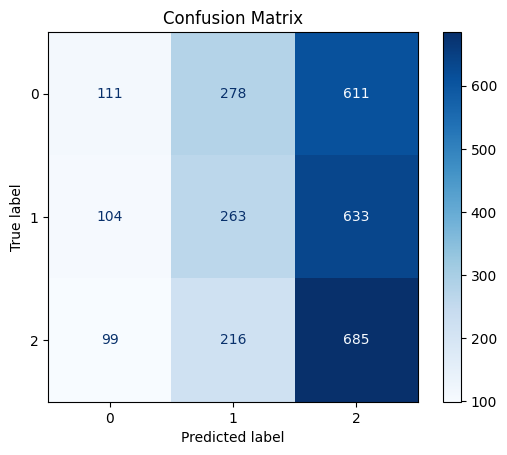

In [61]:
# Generate the confusion matrix, explicitly specifying labels
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])

# Display the confusion matrix with fixed display labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

 
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')
print(f"Recall: {recall:.4f}")

Accuracy: 0.3530
Precision: 0.3520
Recall: 0.3530
